In [124]:
import nideconv
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sn
sn.set(style="ticks")

import pandas as pd
from lmfit import minimize, Parameters, Parameter, report_fit

import sys
import os
import fir
import pickle as pkl

from nilearn import masking, plotting
import nibabel as nib

# many future warnings here, these can be annoying
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns

In [125]:
def get_event_data(subject_id, session, run, bids_root='./data/deriv/fmriprep', 
                   event_types=('go_trial', 'successful_stop', 'failed_stop'),
                   get_jitters=True, drop_duplicates=True):
    """ Loads all event data """
    import pandas

    fn = os.path.join(bids_root, 'sub-' + subject_id, 'ses-' + session, 
                      'func', 'sub-{}_ses-{}_task-stop_run-{}_events.tsv'.format(subject_id, session, run))
    df = pandas.read_csv(fn, sep='\t')

    # Since many subjects do not have errors and we want the design matrices to be the same(did I write this??)
    # across subjects, we only look at correct trials
    to_return = df[np.in1d(df.trial_type, event_types)].fillna(0.1)

    if drop_duplicates:
        # drop duplicates (double responses on a single trial)
        to_return = to_return.drop_duplicates('onset')
    return to_return

def concat_event_data(subject_id, session, runs=(1,2,3), 
                      n_pulses_per_run=(343, 343, 343), tr=3,  # required for estimating deltas
                      bids_root='./data/deriv/fmriprep', 
                      event_types=('go_trial', 'successful_stop', 'failed_stop'),
                      get_jitters=True,
                      time_delta_between_runs=0):
    """ Concatenates event data to create a single DF for all events across 3 runs. """
    dfs = []
    for i, run in enumerate(runs):
        df = get_event_data(subject_id, session, run, event_types=event_types, get_jitters=get_jitters)
        final_time = df.iloc[-1]['onset']
        if i>0:
            df['onset'] += n_pulses_per_run[i-1]*tr*i + time_delta_between_runs*i  # additional seconds in between?
            df['response_time'] += n_pulses_per_run[i-1]*tr*i + time_delta_between_runs*i # additional seconds in between?
        dfs.append(df)
    df = pd.concat(dfs)
    return df

#concat_event_data('13', 'se')

# Let's extract all mean timeseries first...
def get_func_file_names(sub, session, mask_name, pre_highpassed=False, zscore=False, denoised=False, echo_n=None):
    """ Gets filenames of functional data of a sub&session.
    
    Params
    -------
    pre_highpassed: bool
        Load data that are already highpass filtered?
    denoised (ME only): bool
        Load ME data that are denoised?
    echo_n (ME only): bool
        Load individual echo of ME data?
    zscore: bool
        Load z-scored data? (only used for cache name determination here)
        
    Returns
    -------
    cache_fn: str
        Name of cache file corresponding to current data
    bold_imgs: list of str
        List of paths to bold images of the three runs
    """
    
    if session == 'se':
        cache_fn = os.path.join(deconvolution_cache, 'sub-%s_meants_%s.pkl' %(sub, mask_name))
        bold_imgs = ['./data/deriv/fmriprep/sub-%s/ses-se/func/sub-%s_ses-se_task-stop_run-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'%(sub, sub),
                     './data/deriv/fmriprep/sub-%s/ses-se/func/sub-%s_ses-se_task-stop_run-2_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'%(sub, sub),
                     './data/deriv/fmriprep/sub-%s/ses-se/func/sub-%s_ses-se_task-stop_run-3_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'%(sub, sub)
                    ]
    elif session == 'me':
        if denoised:
            cache_fn = os.path.join(deconvolution_cache, 'sub-%s_meants_tedana-denoised_%s.pkl' %(sub, mask_name))
            bold_imgs = ['./tedana_denoising/TED.sub-%s_ses-me_task-stop_run-1_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_hp_fwhm32/dn_ts_OC.nii'%(sub),
                         './tedana_denoising/TED.sub-%s_ses-me_task-stop_run-2_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_hp_fwhm32/dn_ts_OC.nii'%(sub),
                         './tedana_denoising/TED.sub-%s_ses-me_task-stop_run-3_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_hp_fwhm32/dn_ts_OC.nii'%(sub)
                        ]
        else:
            if echo_n is None:
                # load combined ME data
                cache_fn = os.path.join(deconvolution_cache, 'sub-%s_meants_me-optcomb_%s.pkl' %(sub, mask_name))
                bold_imgs = ['./data/deriv/fmriprep/sub-%s/ses-me/func/sub-%s_ses-me_task-stop_run-1_optcomb_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'%(sub, sub),
                             './data/deriv/fmriprep/sub-%s/ses-me/func/sub-%s_ses-me_task-stop_run-2_optcomb_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'%(sub, sub),
                             './data/deriv/fmriprep/sub-%s/ses-me/func/sub-%s_ses-me_task-stop_run-3_optcomb_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'%(sub, sub)
                            ]
            else:
                # load individual echo
                cache_fn = os.path.join(deconvolution_cache, 'sub-%s_meants_me-echo-%d_%s.pkl' %(sub, echo_n, mask_name))
                bold_imgs = ['./data/deriv/fmriprep/sub-%s/ses-me/func/sub-%s_ses-me_task-stop_run-1_echo-%d_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'%(sub, echo_n, sub),
                             './data/deriv/fmriprep/sub-%s/ses-me/func/sub-%s_ses-me_task-stop_run-2_echo-%d_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'%(sub, echo_n, sub),
                             './data/deriv/fmriprep/sub-%s/ses-me/func/sub-%s_ses-me_task-stop_run-3_echo-%d_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'%(sub, echo_n, sub)
                            ]
    
    # check highpass, zscore options
    if pre_highpassed:
        bold_imgs = [x.replace('.nii.gz', '_hp.nii.gz') for x in bold_imgs]
        cache_fn = cache_fn.replace('.pkl', '_hp.pkl')
    if not zscore:
        cache_fn = cache_fn.replace('.pkl', '_nonzscored.pkl')
        
    return cache_fn, bold_imgs


def get_mean_ts(sub, session, mask_name, mask_threshold=1/3., zscore=False, pre_highpassed=False,
                denoised=False, echo_n=None, cache_only=False, overwrite_cache=False, verbose=False,
                truely_raw=False):
    """ Get mean timeseries within a mask of a sub, session, mask """
    
    if verbose:
        print(sub, end='...')
        
    # mask name
    mask_img = './masks/final_masks_mni09a_1p6mm/%s_def-img.nii.gz' %(mask_name)
    
    # filenames of functional data
    cache_fn, bold_imgs = get_func_file_names(sub=sub, session=session, mask_name=mask_name, 
                                              pre_highpassed=pre_highpassed, zscore=zscore,
                                              denoised=denoised, echo_n=echo_n)
    if os.path.exists(cache_fn) and not overwrite_cache:
        if verbose:
            print(' Reading from cache...', end='')
        with open(cache_fn, 'rb') as f:
            tmp = pkl.load(f)
    else:
        if cache_only:
            return None
        if (pre_highpassed and not zscore) or truely_raw:
            return_raw = True
        else:
            return_raw = False
            # returns "raw" data (no zscore, no highpass filtering)
        
        tmp = create_single_timeseries(bold_imgs, mask=mask_img, mask_threshold=mask_threshold, 
                                       zscore=zscore, return_raw=return_raw)
        with open(cache_fn, 'wb') as f:
            pkl.dump(tmp, f)
            
    return tmp

In [126]:
def get_all_ts(sub, ses, run):
    dat = pd.read_csv('./deconvolution_cache/sub-%s_ses-%s_run-%d_all_ts_confs-movpar_psc.tsv' %(str(sub).zfill(2), ses, run), sep='\t')
    return dat

In [127]:
### Rois in MNI09-space
final_masks_mni09a_1p6mm = './masks/final_masks_mni09a_1p6mm'
roi_dict_mni09a = {
    'STR_L': final_masks_mni09a_1p6mm + '/STR_L_def-img.nii.gz',
    'STR_R': final_masks_mni09a_1p6mm + '/STR_R_def-img.nii.gz',
    'STN_L': final_masks_mni09a_1p6mm + '/STN_L_def-img.nii.gz',
    'STN_R': final_masks_mni09a_1p6mm + '/STN_R_def-img.nii.gz',
    'GPi_L': final_masks_mni09a_1p6mm + '/GPi_L_def-img.nii.gz',
    'GPi_R': final_masks_mni09a_1p6mm + '/GPi_R_def-img.nii.gz',
    'GPe_L': final_masks_mni09a_1p6mm + '/GPe_L_def-img.nii.gz',
    'GPe_R': final_masks_mni09a_1p6mm + '/GPe_R_def-img.nii.gz',
    'PreSMA_L': final_masks_mni09a_1p6mm + '/PreSMA_L_def-img.nii.gz',
    'PreSMA_R': final_masks_mni09a_1p6mm + '/PreSMA_R_def-img.nii.gz',
    'rIFG': final_masks_mni09a_1p6mm + '/rIFG_def-img.nii.gz',
    'ACC': final_masks_mni09a_1p6mm + '/ACC_def-img.nii.gz',
    'M1': final_masks_mni09a_1p6mm + '/M1_def-img.nii.gz',
    'M1_R': final_masks_mni09a_1p6mm + '/M1_R_def-img.nii.gz',
    'M1_L': final_masks_mni09a_1p6mm + '/M1_L_def-img.nii.gz',
}

# make nice plot
from nilearn import image
combined = image.concat_imgs(roi_dict_mni09a.values())

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

roi_atlas = AttrDict({'maps': combined,
                      'labels': roi_dict_mni09a.keys()})

In [128]:
# from nilearn import plotting
# from nilearn._utils import check_niimg
# maps = check_niimg(combined)
# # maps.shape
# # if len(maps.shape) == 3:
# #     atlas_type = 'labels'
# # else:
# # atlas_type = 'prob'

In [129]:
## Get timeseries, but now *cleaned*
from nideconv.utils import roi
import pandas as pd
from nilearn import plotting


# roi_atlas
mask_threshold_dict = {
    'STN_L': 0.3,
    'M1_R': 0.3,
    'M1_L': 0.3,
    'STN_R': 0.3,
    'STR_L': 0.3,
    'STR_R': 0.3,
    'PreSMA_L': 0.3, # THIS DOES NOTHING (preSMA isnt a probabilitic map. This value is included here for compatibility)
    'PreSMA_R': 0.3, # THIS DOES NOTHING
    'ACC': 0.3,
    'rIFG': 0.3,
    'GPi_L': 0.3,
    'GPi_R': 0.3,
    'GPe_L': 0.3,
    'GPe_R': 0.3,
    'M1': 0.3,
}


# for sub in range(1, 19):
#     print(sub)
#     if sub == 12:
#         continue
#     sub_str = str(sub).zfill(2)
#     for run in [1,2,3]:
#         print(run)
#         func = './data/deriv/fmriprep/sub-%s/ses-se/func/sub-%s_ses-se_task-stop_run-%d_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz' %(sub_str, sub_str, run)
#         confounds_fn = './data/deriv/fmriprep/sub-%s/ses-se/func/sub-%s_ses-se_task-stop_run-%d_bold_confounds.tsv' %(sub_str, sub_str, run)
#         confounds = pd.read_table(confounds_fn).fillna(method='bfill')

#         confounds_to_include = ['FramewiseDisplacement', 'aCompCor00',
#                                 'aCompCor01', 'aCompCor02', 'aCompCor03',
#                                 'aCompCor04', 'aCompCor05', 'X', 'Y', 'Z',
#                                 'RotX', 'RotY', 'RotZ']
#         confounds = confounds[confounds_to_include]
        
#         ts = roi.extract_timecourse_from_nii(roi_atlas, func,
#                                              confounds=confounds.values,
#                                              t_r=3,
#                                              high_pass=1./128,
#                                              detrend=False,
#                                              standardize='pct')
#         ts.to_csv('./deconvolution_cache/sub-%s_ses-%s_run-%d_all_ts.tsv' %(sub_str, 'se', run), sep='\t')

In [130]:
# def get_all_ts_single_sub(sub, maps, labels, ses='se', cache_fn='/home/stevenm/MultiEchoEPISeq/deconvolution_cache/'):
#     if sub == 12:
#         return 0
    
#     class AttrDict(dict):
#         def __init__(self, *args, **kwargs):
#             super(AttrDict, self).__init__(*args, **kwargs)
#             self.__dict__ = self

#     roi_atlas = AttrDict({'maps': maps,
#                           'labels': labels})
    
#     sub_str = str(sub).zfill(2)
#     for run in [1,2,3]:
#         cache_fn_this_run = cache_fn + 'sub-%s_ses-%s_run-%d_all_ts_

In [136]:
def get_all_ts_single_sub(sub, maps, labels, ses='se', denoised=False,
                          standardize='psc',
                          cache_fn='/home/stevenm/MultiEchoEPISeq/deconvolution_cache/'):
    if sub == 12:
        return 0
    
    class AttrDict(dict):
        def __init__(self, *args, **kwargs):
            super(AttrDict, self).__init__(*args, **kwargs)
            self.__dict__ = self

    roi_atlas = AttrDict({'maps': maps,
                          'labels': labels})
    
    denoised_str = 'denoised_' if denoised else ''
    sub_str = str(sub).zfill(2)
    for run in [1,2,3]:
        cache_fn_this_run = cache_fn + 'sub-%s_ses-%s_%srun-%d_all_ts_confs-none_psc.tsv' %(sub_str, ses, denoised_str, run)
        if os.path.exists(cache_fn_this_run):
            if run < 3:
                continue
            else:
                return 0
            
        print('%s, %d' %(sub_str, run))
        if ses == 'se':
            func = './data/deriv/fmriprep/sub-%s/ses-se/func/sub-%s_ses-se_task-stop_run-%d_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz' %(sub_str, sub_str, run)
            confounds_fn = './data/deriv/fmriprep/sub-%s/ses-se/func/sub-%s_ses-se_task-stop_run-%d_bold_confounds.tsv' %(sub_str, sub_str, run)
        elif ses == 'me':
            if not denoised:
                func = './data/deriv/fmriprep/sub-%s/ses-me/func/sub-%s_ses-me_task-stop_run-%d_optcomb_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_hp.nii.gz' %(sub_str, sub_str, run)
                confounds_fn = './data/deriv/fmriprep/sub-%s/ses-se/func/sub-%s_ses-se_task-stop_run-%d_bold_confounds.tsv' %(sub_str, sub_str, run)
            else:
#                raise(IOError('NOT YET IMPLEMENTED!!!'))
                func = './tedana_denoising/TED.sub-%s_ses-me_task-stop_run-%d_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_hp_fwhm32/dn_ts_OC.nii' %(sub_str, run)
                confounds_fn = './data/deriv/fmriprep/sub-%s/ses-me/func/sub-%s_ses-me_task-stop_run-%d_echo-1_bold_confounds.tsv' %(sub_str, sub_str, run)
        confounds = pd.read_table(confounds_fn).fillna(method='bfill')
        confounds_to_include = []#'FramewiseDisplacement', 
#                                 'aCompCor00',
#                                 'aCompCor01', 'aCompCor02', 'aCompCor03',
#                                 'aCompCor04', 'aCompCor05', 
#                                 'X', 'Y', 'Z',
#                                 'RotX', 'RotY', 'RotZ']
        confounds = confounds[confounds_to_include]
        
        ts = roi.extract_timecourse_from_nii(roi_atlas, func,
                                             confounds=confounds.values,
                                             t_r=3,
                                             high_pass=1./128,
                                             detrend=True,
                                             standardize='psc')
        ts.to_csv(cache_fn_this_run, sep='\t')
    
    return ts

In [132]:
# serially
# for sub in range(1,19):
#     if sub == 0 or sub == 12:
#         continue
#     get_all_ts_single_sub(sub, ses='se', maps=roi_atlas['maps'], labels=[x for x in roi_atlas['labels']],
#                           cache_fn='/home/stevenm/MultiEchoEPISeq/deconvolution_cache/')

In [137]:
# parallel
import multiprocessing as mp
from functools import partial

subs = np.arange(1, 19)

with mp.Pool(3) as p:
    p.map(partial(get_all_ts_single_sub,
                  ses='me', maps=roi_atlas['maps'], labels=[x for x in roi_atlas['labels']],
                  cache_fn='/home/stevenm/MultiEchoEPISeq/deconvolution_cache/'),
          subs)


01, 1
03, 1
05, 1
01, 2
03, 2
05, 2
01, 3
03, 3
05, 3
02, 1
06, 1
04, 1
02, 2
06, 2
04, 2
02, 3
06, 3
04, 3
07, 1
09, 1
11, 1
07, 2
09, 2
11, 2
07, 3
09, 3
11, 3
08, 1
10, 1
13, 1
08, 2
10, 2
13, 2
08, 3
10, 3
13, 3
15, 1
17, 1
14, 1
15, 2
17, 2
14, 2
15, 3
17, 3
14, 3
16, 1
18, 1
16, 2
18, 2
16, 3
18, 3


ValueError: Confound signal has an incorrect length

In [19]:
# sub_str = '01'
# run = 1
# confounds_fn = './data/deriv/fmriprep/sub-%s/ses-se/func/sub-%s_ses-se_task-stop_run-%d_bold_confounds.tsv' %(sub_str, sub_str, run)
# confounds = pd.read_table(confounds_fn).fillna(method='bfill')

# confounds_to_include = ['FramewiseDisplacement', 'aCompCor00',
#                         'aCompCor01', 'aCompCor02', 'aCompCor03',
#                         'aCompCor04', 'aCompCor05', 'X', 'Y', 'Z',
#                         'RotX', 'RotY', 'RotZ']

In [93]:
mask_name = 'PreSMA_L'
sub = '01'
ses = 'se'
denoised=False
pre_highpassed=True
cache_only=True
zscore=False
# Set-up
deconvolution_cache = './deconvolution_cache'
if not os.path.exists(deconvolution_cache):
    os.mkdir(deconvolution_cache)

# some settings for deconvolution
interval = 18  # BOLD response takes about ~18 sec
tr=3.
sample_rate = 1/tr

In [94]:
# mask_img = './masks/final_masks_mni09a_1p6mm/%s_def-img.nii.gz' %(mask_name)
# func_timeseries = get_mean_ts(sub, session=ses, mask_name=mask_name, 
#                               pre_highpassed=pre_highpassed, denoised=denoised,
#                               cache_only=cache_only, zscore=zscore)


In [95]:
# all_events = get_event_data(sub, ses, 1)
# go_trials = all_events.loc[all_events['trial_type'] == 'go_trial',]
# successful_stop = all_events.loc[all_events['trial_type'] == 'successful_stop',]
# failed_stop = all_events.loc[all_events['trial_type'] == 'failed_stop',]

In [80]:
# rf = nideconv.ResponseFitter(func_timeseries[0], sample_rate=sample_rate,
#                             oversample_design_matrix=30)
# rf.add_event(event_name='go', onset_times=all_events.loc[all_events['trial_type']=='go_trial', 'onset'],
#              interval=[0,18])
# rf.add_event(event_name='failed_stop', onset_times=all_events.loc[all_events['trial_type']=='failed_stop', 'onset'],
#              interval=[0,18])
# rf.add_event(event_name='successful_stop', onset_times=all_events.loc[all_events['trial_type']=='successful_stop', 'onset'],
#              interval=[0,18])

/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)


In [81]:
# rf.regress()

In [96]:
# rf.betas

In [97]:
# sns.set_style('white')
# sns.set_context('notebook')
# palette = sns.color_palette('Set1')
# sns.set_palette(palette)
# rf.plot_timecourses()
# plt.suptitle('Linear deconvolution using GLM and FIR')
# plt.title('')
# plt.legend()

In [98]:
# def as_pct_signal_change(ts):
#     return ts/ts.mean()*100-100

In [99]:
# # Concatenate runs
# rfs = []
# for run in [1,2,3]:
#     this_timeseries = as_pct_signal_change(func_timeseries[run-1])
#     rf = nideconv.ResponseFitter(this_timeseries, 
#                                  sample_rate=sample_rate,
#                                  oversample_design_matrix=30)
#     all_events = get_event_data(sub, ses, run)
#     rf.add_event(event_name='go', onset_times=all_events.loc[all_events['trial_type']=='go_trial', 'onset'],
#                  interval=[0,18])
#     rf.add_event(event_name='failed_stop', onset_times=all_events.loc[all_events['trial_type']=='failed_stop', 'onset'],
#                  interval=[0,18])
#     rf.add_event(event_name='successful_stop', onset_times=all_events.loc[all_events['trial_type']=='successful_stop', 'onset'],
#                  interval=[0,18])
#     rfs.append(rf)

In [100]:
# crf = nideconv.ConcatenatedResponseFitter(rfs)

In [101]:
# crf.regress()

In [102]:
# sns.set_style('white')
# sns.set_context('notebook')
# palette = sns.color_palette('Set1')
# sns.set_palette(palette)
# crf.plot_timecourses()
# plt.suptitle('Linear deconvolution using GLM and FIR')
# plt.title('')
# plt.legend()

In [103]:
# sub

In [104]:
# mask_name

In [105]:
# pd.concat()

In [106]:
# def get_session_timeseries(ses, mask_name, pre_highpassed=True, denoised=False,
#                            cache_only=True, zscore=False):
    
#     if isinstance(mask_name, str):
#         mask_name = [mask_name]

#     dfs = []
#     for sub in range(1,19):
#         if sub == 12:
#             continue
#         sub = str(sub).zfill(2)
        
#         for run in [1,2,3]:
#             rois_this_run = []
#             for roi in mask_name:
#                 timeseries = get_mean_ts(sub, session=ses, mask_name=roi, 
#                                          pre_highpassed=pre_highpassed, denoised=denoised,
#                                          cache_only=cache_only, zscore=zscore)
#                 timeseries = as_pct_signal_change(timeseries[run-1])
                
#                 rois_this_run.append(pd.DataFrame({roi: timeseries}))
#             roi_df = pd.concat(rois_this_run, axis=1)
#             roi_df['subject'] = sub
#             roi_df['run'] = run
#             dfs.append(roi_df)
            
#     all_dat = pd.concat(dfs)
#     all_dat['session'] = ses
#     all_dat = all_dat.set_index(['subject', 'session', 'run'])
#     return all_dat

def get_session_timeseries(ses):

    dfs = []
    for sub in range(1,19):
        if sub == 12:
            continue
        sub = str(sub).zfill(2)
        
        for run in [1,2,3]:
            ts = get_all_ts(sub, ses, run)
            ts['subject'] = sub
            ts['run'] = run
            ts.drop(labels='time', axis=1, inplace=True)
            dfs.append(ts)
            
    all_dat = pd.concat(dfs)
    all_dat['session'] = ses
    all_dat = all_dat.set_index(['subject', 'session', 'run'])
    return all_dat

def get_all_onsets(ses, event_types=('go_trial', 'failed_stop', 'successful_stop')):
    onset_dfs = []
    for sub in range(1,19):
        if sub == 12:
            continue
        sub = str(sub).zfill(2)

        for run in [1,2,3]:
            onsets_this_run = get_event_data(sub, ses, run)
            onsets_this_run['subject'] = sub
            onsets_this_run['session'] = ses
            onset_dfs.append(onsets_this_run)

    onsets = pd.concat(onset_dfs)
    onsets = onsets.loc[onsets.trial_type.isin(event_types),
                        ['subject', 'session', 'run','trial_type', 'onset', 'duration']]
    onsets = onsets.set_index(['subject', 'session', 'run'])
    return onsets

In [107]:
# get_all_ts('01', 'se', 1)

In [119]:
rfGroups = {}
masks = ['STN_R', 'STN_L', 'STR_R', 'STR_L', 'PreSMA_L', 'PreSMA_R', 'M1', 'GPe_L', 'GPe_R']
for ses in ['se']:

    # get relevant data
    ts = get_session_timeseries(ses)
    onsets = get_all_onsets(ses=ses)

    # deconvolve
    rfGroup = nideconv.GroupResponseFitter(ts, onsets, 1/3., oversample_design_matrix=10)
    rfGroup.add_event(interval=[0,18], n_regressors=7)
    rfGroup.fit()

    rfGroups[ses] = rfGroup

/home/stevenm/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2817: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/home/stevenm/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [120]:
def plot_single_mask_timecourses(rfGroup,
                                 mask_name,
                                 ax=None, legend=False):
    
    if ax is None:
        f, ax = plt.subplots(11)
    
    tc = rfGroup.get_subjectwise_timecourses(oversample=None, melt=True)
    sns.tsplot(tc.loc[tc['roi']==mask_name], time='time', unit='subject', 
               condition='event type', value='value', ax=ax, legend=False)
    ax.axhline(y=0, c='k', ls='--')
    ax.axvline(x=0, c='k', ls='--')
    

/home/stevenm/miniconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/stevenm/miniconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/stevenm/miniconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/stevenm/miniconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new

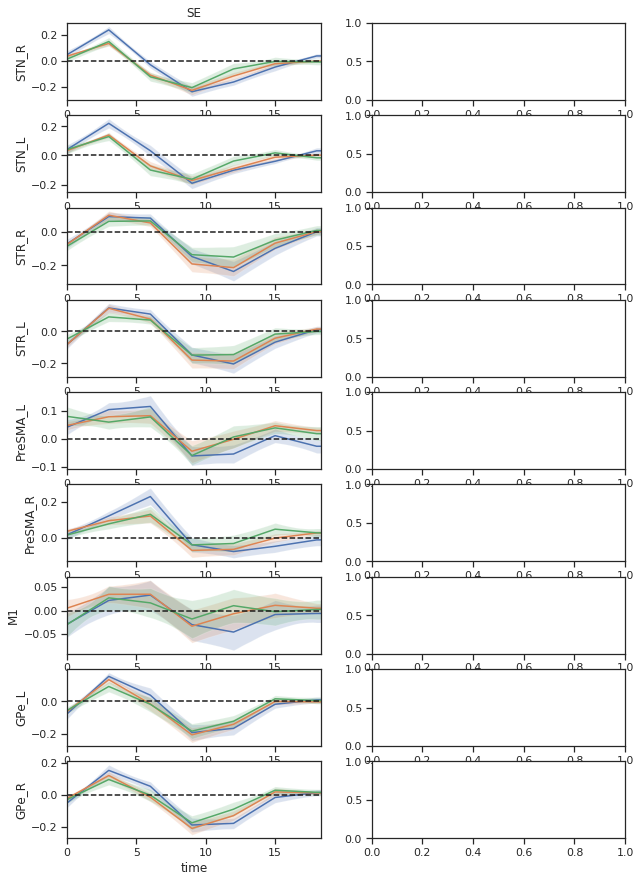

In [121]:
f, axes = plt.subplots(len(masks), 2)

for row, mask in enumerate(masks):
    plot_single_mask_timecourses(rfGroups['se'], mask, ax=axes[row,0])
    axes[row,0].set_ylabel(mask)
#     plot_single_mask_timecourses(rfGroups['me'], mask, ax=axes[row,1])
#     axes[row,1].set_ylabel('')
    
    # get maximum ylims, set
    current_ranges = np.array([np.array(x.get_ylim()) for x in axes[row,:1]])
    for ax in axes[row,:1]:
        ax.set_ylim(current_ranges.min(0)[0], current_ranges.max(0)[1])

axes[0,0].set_title('SE')
# axes[0,1].set_title('ME')

f.set_size_inches(10,15)
#     se_axes[row].ax = axes[row,0]# = se_axes[row]
#     me_axes[row].ax = axes[row,1]# = me_axes[row]

/home/stevenm/miniconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/stevenm/miniconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/stevenm/miniconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/stevenm/miniconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new

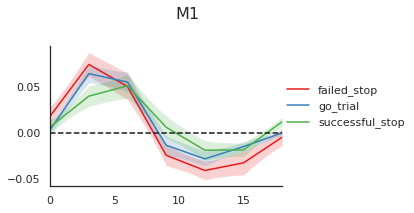

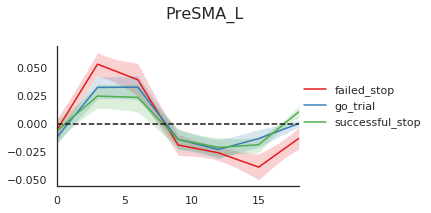

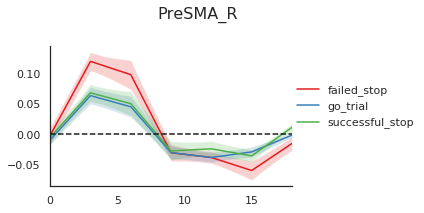

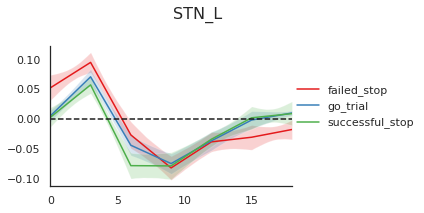

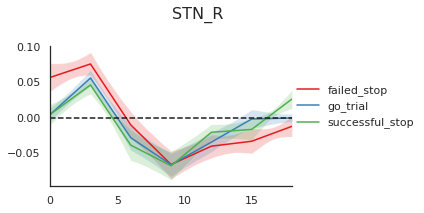

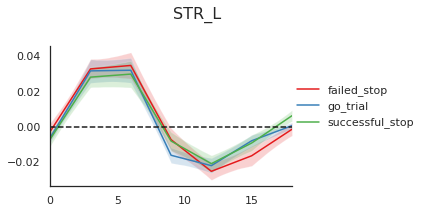

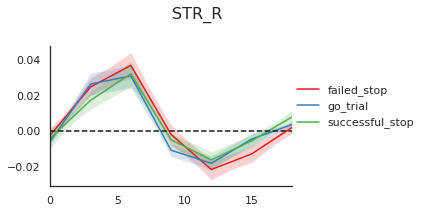

In [250]:
rfGroups['me'].plot_groupwise_timecourses()

/home/stevenm/miniconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/stevenm/miniconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/stevenm/miniconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/stevenm/miniconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new

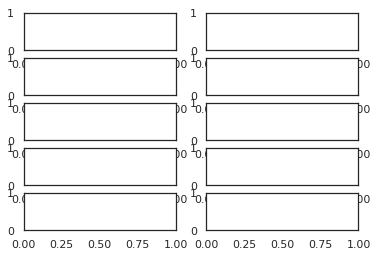

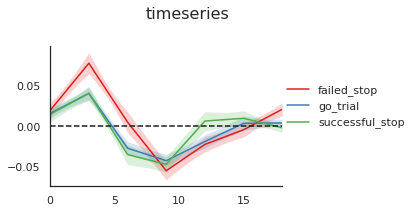

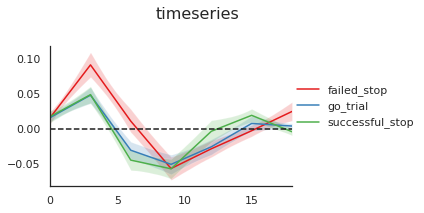

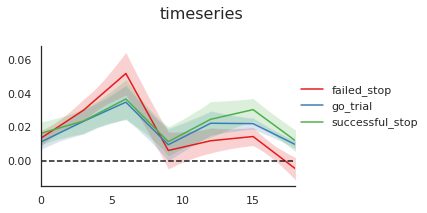

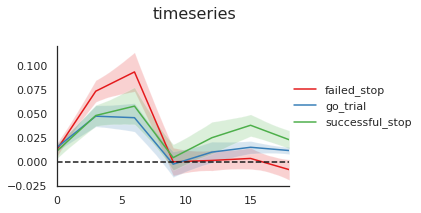

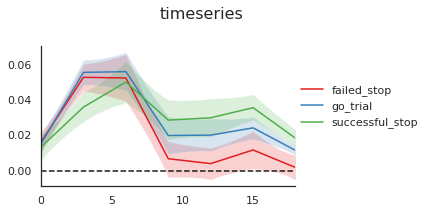

In [230]:
f, axes = plt.subplots(len(rfgroups), 2)

for i, msk, sestypes in enumerate(rfgroups.items()):
    
    sestypes['se'].plot_groupwise_timecourses()

In [202]:
all_dat = pd.concat(dfs)
all_dat = all_dat.set_index(['subject', 'session', 'run'])

In [221]:
onsets

trial_type      onset  duration
subject session run                                      
01      se      1           go_trial     0.7764    1.0171
                1           go_trial    11.2805    1.0170
                1    successful_stop    21.0342    1.0171
                1    successful_stop    27.7702    1.0170
                1    successful_stop    36.7736    1.0171
                1           go_trial    46.5274    1.0171
                1           go_trial    54.7806    1.0170
                1    successful_stop    66.0349    1.0171
                1           go_trial    73.5378    1.0171
                1           go_trial    82.5246    1.0171
                1        failed_stop    92.2784    1.0170
                1           go_trial   102.0321    1.0171
                1           go_trial   108.7847    1.0171
                1        failed_stop   118.5385    1.0171
                1           go_trial   128.2756    1.0171
                1           go_trial   137.2791    1.0170
                1           go_trial   144.7820    1.0170
                1        failed_stop   154.5357    1.0171
                1    successful_stop   164.2895    1.0170
                1           go_trial   174.0266    1.0170
                1           go_trial   183.0299    1.0172
                1           go_trial   192.0335    1.0171
                1    successful_stop   200.2867    1.0170
                1           go_trial   210.0404    1.0171
                1           go_trial   216.7930    1.0171
                1           go_trial   225.7798    1.0171
                1           go_trial   235.5336    1.0171
                1        failed_stop   246.0376    1.0171
                1           go_trial   253.5405    1.0171
                1           go_trial   262.5440    1.0171
...                              ...        ...       ...
18      se      3           go_trial   759.0549    1.0170
                3           go_trial   765.8075    1.0170
                3    successful_stop   776.3115    1.0170
                3           go_trial   784.5646    1.0171
                3           go_trial   792.8011    1.0170
                3        failed_stop   804.0554    1.0170
                3           go_trial   812.3085    1.0171
                3           go_trial   821.3120    1.0170
                3           go_trial   829.5651    1.0171
                3           go_trial   839.3021    1.0171
                3    successful_stop   846.8050    1.0171
                3           go_trial   856.5587    1.0171
                3           go_trial   864.8119    1.0171
                3           go_trial   876.0662    1.0171
                3        failed_stop   884.3194    1.0170
                3    successful_stop   894.0564    1.0171
                3           go_trial   901.5593    1.0170
                3        failed_stop   911.3130    1.0169
                3           go_trial   921.0667    1.0171
                3           go_trial   929.3199    1.0170
                3           go_trial   936.8061    1.0170
                3           go_trial   945.8095    1.0170
                3        failed_stop   955.5632    1.0171
                3           go_trial   964.5667    1.0169
                3           go_trial   972.8198    1.0171
                3           go_trial   982.5569    1.0170
                3           go_trial   991.5603    1.0171
                3           go_trial  1002.0643    1.0171
                3           go_trial  1009.5672    1.0170
                3           go_trial  1018.5706    1.0171

[5813 rows x 3 columns]

In [203]:
onset_dfs = []
for sub in range(1,19):
    if sub == 12:
        continue
    sub = str(sub).zfill(2)
    
    for ses in ['se', 'me']:
        for run in [1,2,3]:
            onsets_this_run = get_event_data(sub, ses, run)
            onsets_this_run['subject'] = int(sub)
            onsets_this_run['session'] = ses
            onset_dfs.append(onsets_this_run)

In [204]:
onsets = pd.concat(onset_dfs)
onsets = onsets.loc[onsets.trial_type.isin(['go_trial', 'failed_stop', 'successful_stop']), ['subject', 'session', 'run','trial_type', 'onset', 'duration']]
onsets = onsets.set_index(['subject', 'session', 'run'])
onsets

trial_type      onset  duration
subject session run                                      
1       se      1           go_trial     0.7764    1.0171
                1           go_trial    11.2805    1.0170
                1    successful_stop    21.0342    1.0171
                1    successful_stop    27.7702    1.0170
                1    successful_stop    36.7736    1.0171
                1           go_trial    46.5274    1.0171
                1           go_trial    54.7806    1.0170
                1    successful_stop    66.0349    1.0171
                1           go_trial    73.5378    1.0171
                1           go_trial    82.5246    1.0171
                1        failed_stop    92.2784    1.0170
                1           go_trial   102.0321    1.0171
                1           go_trial   108.7847    1.0171
                1        failed_stop   118.5385    1.0171
                1           go_trial   128.2756    1.0171
                1           go_trial   137.2791    1.0170
                1           go_trial   144.7820    1.0170
                1        failed_stop   154.5357    1.0171
                1    successful_stop   164.2895    1.0170
                1           go_trial   174.0266    1.0170
                1           go_trial   183.0299    1.0172
                1           go_trial   192.0335    1.0171
                1    successful_stop   200.2867    1.0170
                1           go_trial   210.0404    1.0171
                1           go_trial   216.7930    1.0171
                1           go_trial   225.7798    1.0171
                1           go_trial   235.5336    1.0171
                1        failed_stop   246.0376    1.0171
                1           go_trial   253.5405    1.0171
                1           go_trial   262.5440    1.0171
...                              ...        ...       ...
18      me      3        failed_stop   757.5496    1.0171
                3    successful_stop   766.5530    1.0170
                3           go_trial   777.0569    1.0170
                3    successful_stop   784.5430    1.0170
                3           go_trial   795.0469    1.0170
                3        failed_stop   804.0502    1.0171
                3           go_trial   811.5530    1.0171
                3           go_trial   821.3067    1.0170
                3           go_trial   828.7928    1.0170
                3           go_trial   838.5464    1.0170
                3        failed_stop   849.0503    1.0170
                3           go_trial   855.8028    1.0171
                3           go_trial   866.3067    1.0171
                3        failed_stop   874.5598    1.0170
                3           go_trial   885.0470    1.0171
                3           go_trial   892.5498    1.0171
                3           go_trial   903.0537    1.0171
                3    successful_stop   911.3068    1.0170
                3           go_trial   921.0604    1.0171
                3           go_trial   929.2968    1.0171
                3           go_trial   938.3001    1.0171
                3           go_trial   948.0538    1.0170
                3           go_trial   954.8063    1.0170
                3           go_trial   966.0605    1.0170
                3           go_trial   974.2969    1.0170
                3           go_trial   981.7997    1.0170
                3        failed_stop   991.5533    1.0170
                3    successful_stop  1002.0572    1.0170
                3           go_trial  1011.0605    1.0171
                3    successful_stop  1020.0639    1.0170

[11548 rows x 3 columns]

In [213]:
rfGroup = nideconv.GroupResponseFitter(all_dat, onsets, 1/3.)
rfGroup.add_event(interval=[0,18])

/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' %

/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' %

/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' %

/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' %

/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' %

/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' %

/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' % self.n_regressors)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nideconv/regressors.py:215: UserWarning: Number of FIR regressors has automatically been set to 7 per covariate
  'per covariate' %

In [214]:
rfGroup.fit()

/home/stevenm/miniconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


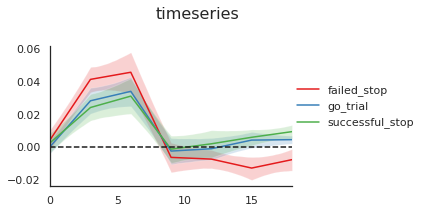

In [215]:
rfGroup.plot_groupwise_timecourses(event_types=['go_trial', 'successful_stop', 'failed_stop'])